In [41]:
import os
import re
import sklearn
import numpy as np 
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *
from sklearn.naive_bayes import GaussianNB

In [42]:
DATA_PATH = 'march-machine-learning-mania-2023/'

## Data Preparation

### Seeds

In [43]:
df_seeds = pd.concat([
  pd.read_csv("march-machine-learning-mania-2023/MNCAATourneySeeds.csv"),
  pd.read_csv("march-machine-learning-mania-2023/WNCAATourneySeeds.csv")
],  ignore_index=True)
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


### Season results

Add total rebounds for each team, and for the whole game (to later calculate rebound percentages)

In [44]:
df_season_results = pd.concat([
  pd.read_csv("march-machine-learning-mania-2023/MRegularSeasonDetailedResults.csv"),
  pd.read_csv("march-machine-learning-mania-2023/WRegularSeasonDetailedResults.csv")
], ignore_index=True)

df_season_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [45]:
df_season_results['WTR'] = df_season_results['WOR'] + df_season_results['WDR']
df_season_results['LTR'] = df_season_results['LOR'] + df_season_results['LDR']
df_season_results['TR'] = df_season_results['WTR'] + df_season_results['LTR']
df_season_results['ScoreGap'] = df_season_results['WScore'] - df_season_results['LScore']

df_season_results.drop(['WStl', 'WBlk', 'WPF', 'LStl', 'LBlk', 'LPF'], axis=1, inplace=True)

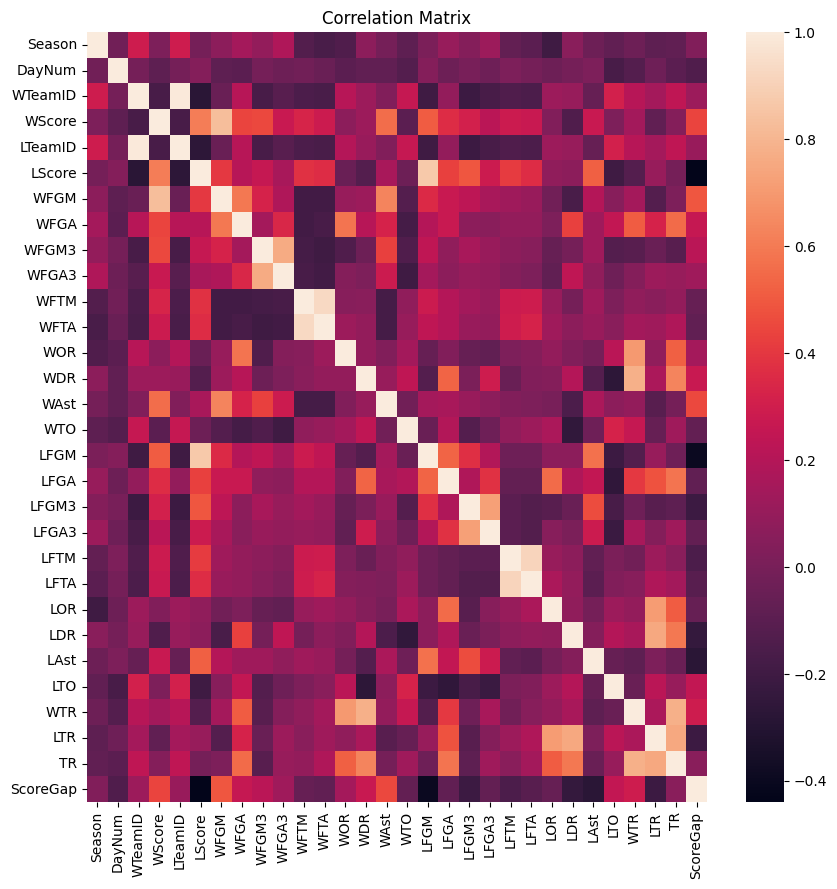

In [46]:
corrs = round(df_season_results.corr(), 2)

import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(corrs)
plt.title('Correlation Matrix')
plt.show()

### Features
Aggregate the results for the fields we will later use for our features.

For each team at each season, computing:
- Number of wins
- Number of losses
- Average score gap of wins
- Average score gap of losses
- Total field goals made and attempted for wins and losses
- Total 3-point field goals made and attempted for wins and losses
- Total free throws made and attempted for wins and losses
- Total rebounds by the team for wins and losses
- Total rebounds in the game for wins and losses
- Total assists for wins and losses
- Total turnovers for wins and losses

And use the following features ([explained here](https://en.wikipedia.org/wiki/Basketball_statistics)):

- Win Ratio
- Average score gap
- Field goal %
- 3-point field goal %
- Free throw %
- [Effective field goal %](https://en.wikipedia.org/wiki/Effective_field_goal_percentage)
- [True shooting %](https://en.wikipedia.org/wiki/True_shooting_percentage)
- Total rebound %
- Assist to turnover ratio
- Turnover %
- Offensive rating (Points scored per possession)
- Defensive rating (Points allowed per opposition possession)
- [Net rating (Offensive rating - Defensive rating)](https://www.pivotanalysis.com/post/net-rating)


In [47]:
num_win = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})
num_loss = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})
gap_win = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()[['Season', 'WTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapWins", "WTeamID": "TeamID"})
gap_loss = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()[['Season', 'LTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapLosses", "LTeamID": "TeamID"})
fgm_win = df_season_results.groupby(['Season', 'WTeamID']).sum().reset_index()[['Season', 'WTeamID', 'WFGM']].rename(columns={"WFGM": "FGMWins", "WTeamID": "TeamID"})
fgm_loss = df_season_results.groupby(['Season', 'LTeamID']).sum().reset_index()[['Season', 'LTeamID', 'LFGM']].rename(columns={"LFGM": "FGMLosses", "LTeamID": "TeamID"})
fga_win = df_season_results.groupby(['Season', 'WTeamID']).sum().reset_index()[['Season', 'WTeamID', 'WFGA']].rename(columns={"WFGA": "FGAWins", "WTeamID": "TeamID"})
fga_loss = df_season_results.groupby(['Season', 'LTeamID']).sum().reset_index()[['Season', 'LTeamID', 'LFGA']].rename(columns={"LFGA": "FGALosses", "LTeamID": "TeamID"})
fgm3_win = df_season_results.groupby(['Season', 'WTeamID']).sum().reset_index()[['Season', 'WTeamID', 'WFGM3']].rename(columns={"WFGM3": "FGM3Wins", "WTeamID": "TeamID"})
fgm3_loss = df_season_results.groupby(['Season', 'LTeamID']).sum().reset_index()[['Season', 'LTeamID', 'LFGM3']].rename(columns={"LFGM3": "FGM3Losses", "LTeamID": "TeamID"})
fga3_win = df_season_results.groupby(['Season', 'WTeamID']).sum().reset_index()[['Season', 'WTeamID', 'WFGA3']].rename(columns={"WFGA3": "FGA3Wins", "WTeamID": "TeamID"})
fga3_loss = df_season_results.groupby(['Season', 'LTeamID']).sum().reset_index()[['Season', 'LTeamID', 'LFGA3']].rename(columns={"LFGA3": "FGA3Losses", "LTeamID": "TeamID"})
ftm_win = df_season_results.groupby(['Season', 'WTeamID']).sum().reset_index()[['Season', 'WTeamID', 'WFTM']].rename(columns={"WFTM": "FTMWins", "WTeamID": "TeamID"})
ftm_loss = df_season_results.groupby(['Season', 'LTeamID']).sum().reset_index()[['Season', 'LTeamID', 'LFTM']].rename(columns={"LFTM": "FTMLosses", "LTeamID": "TeamID"})
fta_win = df_season_results.groupby(['Season', 'WTeamID']).sum().reset_index()[['Season', 'WTeamID', 'WFTA']].rename(columns={"WFTA": "FTAWins", "WTeamID": "TeamID"})
fta_loss = df_season_results.groupby(['Season', 'LTeamID']).sum().reset_index()[['Season', 'LTeamID', 'LFTA']].rename(columns={"LFTA": "FTALosses", "LTeamID": "TeamID"})
teamreb_win = df_season_results.groupby(['Season', 'WTeamID']).sum().reset_index()[['Season', 'WTeamID', 'WTR']].rename(columns={"WTR": "TeamRebWins", "WTeamID": "TeamID"})
teamreb_loss = df_season_results.groupby(['Season', 'LTeamID']).sum().reset_index()[['Season', 'LTeamID', 'LTR']].rename(columns={"LTR": "TeamRebLosses", "LTeamID": "TeamID"})
gamereb_win = df_season_results.groupby(['Season', 'WTeamID']).sum().reset_index()[['Season', 'WTeamID', 'TR']].rename(columns={"TR": "GameRebWins", "WTeamID": "TeamID"})
gamereb_loss = df_season_results.groupby(['Season', 'LTeamID']).sum().reset_index()[['Season', 'LTeamID', 'TR']].rename(columns={"TR": "GameRebLosses", "LTeamID": "TeamID"})
ast_win = df_season_results.groupby(['Season', 'WTeamID']).sum().reset_index()[['Season', 'WTeamID', 'WAst']].rename(columns={"WAst": "AstWins", "WTeamID": "TeamID"})
ast_loss = df_season_results.groupby(['Season', 'LTeamID']).sum().reset_index()[['Season', 'LTeamID', 'LAst']].rename(columns={"LAst": "AstLosses", "LTeamID": "TeamID"})
to_win = df_season_results.groupby(['Season', 'WTeamID']).sum().reset_index()[['Season', 'WTeamID', 'WTO']].rename(columns={"WTO": "TOWins", "WTeamID": "TeamID"})
to_loss = df_season_results.groupby(['Season', 'LTeamID']).sum().reset_index()[['Season', 'LTeamID', 'LTO']].rename(columns={"LTO": "TOLosses", "LTeamID": "TeamID"})
opp_pts_win = df_season_results.groupby(['Season', 'WTeamID']).sum().reset_index()[['Season', 'WTeamID', 'LScore']].rename(columns={"LScore": "oppPTSWins", "WTeamID": "TeamID"})
opp_pts_loss = df_season_results.groupby(['Season', 'LTeamID']).sum().reset_index()[['Season', 'LTeamID', 'WScore']].rename(columns={"WScore": "oppPTSLosses", "LTeamID": "TeamID"})
opp_fga_win = df_season_results.groupby(['Season', 'WTeamID']).sum().reset_index()[['Season', 'WTeamID', 'LFGA']].rename(columns={"LFGA": "oppFGAWins", "WTeamID": "TeamID"})
opp_fga_loss = df_season_results.groupby(['Season', 'LTeamID']).sum().reset_index()[['Season', 'LTeamID', 'WFGA']].rename(columns={"WFGA": "oppFGALosses", "LTeamID": "TeamID"})
opp_fta_win = df_season_results.groupby(['Season', 'WTeamID']).sum().reset_index()[['Season', 'WTeamID', 'LFTA']].rename(columns={"LFTA": "oppFTAWins", "WTeamID": "TeamID"})
opp_fta_loss = df_season_results.groupby(['Season', 'LTeamID']).sum().reset_index()[['Season', 'LTeamID', 'WFTA']].rename(columns={"WFTA": "oppFTALosses", "LTeamID": "TeamID"})
opp_to_win = df_season_results.groupby(['Season', 'WTeamID']).sum().reset_index()[['Season', 'WTeamID', 'LTO']].rename(columns={"LTO": "oppTOWins", "WTeamID": "TeamID"})
opp_to_loss = df_season_results.groupby(['Season', 'LTeamID']).sum().reset_index()[['Season', 'LTeamID', 'WTO']].rename(columns={"WTO": "oppTOLosses", "LTeamID": "TeamID"})


In [48]:
df_features_season_w = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})
df_features_season = pd.concat([
  df_features_season_w, 
  df_features_season_l
], axis=0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

#### Merge, compute aggregates

In [49]:
df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fgm_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fgm_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fga_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fga_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fgm3_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fgm3_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fga3_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fga3_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(ftm_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(ftm_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fta_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(fta_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(teamreb_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(teamreb_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gamereb_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gamereb_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(ast_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(ast_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(to_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(to_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(opp_pts_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(opp_pts_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(opp_fga_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(opp_fga_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(opp_fta_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(opp_fta_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(opp_to_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(opp_to_loss, on=['Season', 'TeamID'], how='left')

df_features_season.fillna(0, inplace=True)

df_features_season['FGM'] = df_features_season['FGMWins'] + df_features_season['FGMLosses']
df_features_season['FGA'] = df_features_season['FGAWins'] + df_features_season['FGALosses']
df_features_season['FGM3'] = df_features_season['FGM3Wins'] + df_features_season['FGM3Losses']
df_features_season['FGA3'] = df_features_season['FGA3Wins'] + df_features_season['FGA3Losses']
df_features_season['FTM'] = df_features_season['FTMWins'] + df_features_season['FTMLosses']
df_features_season['FTA'] = df_features_season['FTAWins'] + df_features_season['FTALosses']
df_features_season['TeamReb'] = df_features_season['TeamRebWins'] + df_features_season['TeamRebLosses']
df_features_season['GameReb'] = df_features_season['GameRebWins'] + df_features_season['GameRebLosses']
df_features_season['Ast'] = df_features_season['AstWins'] + df_features_season['AstLosses']
df_features_season['TO'] = df_features_season['TOWins'] + df_features_season['TOLosses']
df_features_season['PTS'] = 2 * df_features_season['FGM'] + df_features_season['FGM3'] + df_features_season['FTM']
df_features_season['POSS'] = df_features_season['FGA'] + 0.44 * df_features_season['FTA'] + df_features_season['TO']
df_features_season['oppPTS'] = df_features_season['oppPTSWins'] + df_features_season['oppPTSLosses']
df_features_season['oppFGA'] = df_features_season['oppFGAWins'] + df_features_season['oppFGALosses']
df_features_season['oppFTA'] = df_features_season['oppFTAWins'] + df_features_season['oppFTALosses']
df_features_season['oppTO'] = df_features_season['oppTOWins'] + df_features_season['oppTOLosses']
df_features_season['oppPOSS'] = df_features_season['oppFGA'] + 0.44 * df_features_season['oppFTA'] + df_features_season['oppTO']

#### Compute features

In [50]:
df_features_season['WinRatio'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])
df_features_season['GapAvg'] = (
    (df_features_season['NumWins'] * df_features_season['GapWins'] - 
    df_features_season['NumLosses'] * df_features_season['GapLosses'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)
df_features_season['FieldGoal%'] = df_features_season['FGM'] / df_features_season['FGA']
df_features_season['3PointFG%'] = df_features_season['FGM3'] / df_features_season['FGA3']
df_features_season['FreeThrow%'] = df_features_season['FTM'] / df_features_season['FTA']
df_features_season['effectiveFG%'] = (df_features_season['FGM'] + 0.5 * df_features_season['FGM3']) / df_features_season['FGA']
df_features_season['TrueShooting%'] = df_features_season['PTS'] / (2 * df_features_season['FGA'] + 0.88 * df_features_season['FTA'])
df_features_season['TotalRebound%'] = df_features_season['TeamReb'] / df_features_season['GameReb']
df_features_season['AssistToTurnover'] = df_features_season['Ast'] / df_features_season['TO']
df_features_season['Turnover%'] = df_features_season['TO'] / df_features_season['POSS']
df_features_season['OffRating'] = df_features_season['PTS'] / df_features_season['POSS'] * 100
df_features_season['DefRating'] = df_features_season['oppPTS'] / df_features_season['oppPOSS'] * 100
df_features_season['NetRating'] = df_features_season['OffRating'] - df_features_season['DefRating']

# features = ['FieldGoal%', '3PointFG%', 'FreeThrow%', 'effectiveFG%', 'TrueShooting%', 'TotalRebound%', 'AssistToTurnover', 'Turnover%', 'OffRating', 'DefRating', 'NetRating']
features = ['TrueShooting%', 'TotalRebound%', 'AssistToTurnover', 'OffRating', 'DefRating', 'NetRating']
targets = ['WinRatio', 'GapAvg']

keep = ['Season', 'TeamID'] + features + targets
df_features_season.drop([col for col in df_features_season.columns.values if col not in keep], axis=1, inplace=True)
df_features_season.head()

,Season,TeamID,WinRatio,GapAvg,TrueShooting%,TotalRebound%,AssistToTurnover,OffRating,DefRating,NetRating
0,2003,1102,0.428571,0.250000,0.605015,0.413793,1.137500,97.461028,89.253758,8.207270
1,2003,1103,0.481481,0.629630,0.585912,0.465738,1.205279,98.649426,95.211451,3.437975
2,2003,1104,0.607143,4.285714,0.521831,0.527903,0.911290,86.962758,84.525358,2.437401
3,2003,1105,0.269231,-4.884615,0.503801,0.480565,0.779381,79.848690,86.566360,-6.717671
4,2003,1106,0.464286,-0.142857,0.508613,0.517647,0.685535,79.942904,81.596270,-1.653366


#### Correlations

In [51]:
def correlations(df, features, target, extra = ''):
  corrs = {}
  for feature in features + [extra]:
    if feature in df.columns:
      corrs[feature] = round(df[feature].corr(df[target]), 4)
  return dict(sorted(corrs.items(), key=lambda item: abs(item[1]), reverse=True))

Correlations with WinRatio

In [52]:
correlations(df_features_season, features, 'WinRatio')

{'NetRating': 0.9254,
 'TotalRebound%': 0.6162,
 'AssistToTurnover': 0.5919,
 'OffRating': 0.5659,
 'TrueShooting%': 0.5367,
 'DefRating': -0.4569}

Correlation with GapAvg (aka avg +/-)

In [53]:
correlations(df_features_season, features, 'GapAvg')

{'NetRating': 0.9671,
 'TotalRebound%': 0.6637,
 'AssistToTurnover': 0.637,
 'OffRating': 0.5992,
 'TrueShooting%': 0.5656,
 'DefRating': -0.4685}

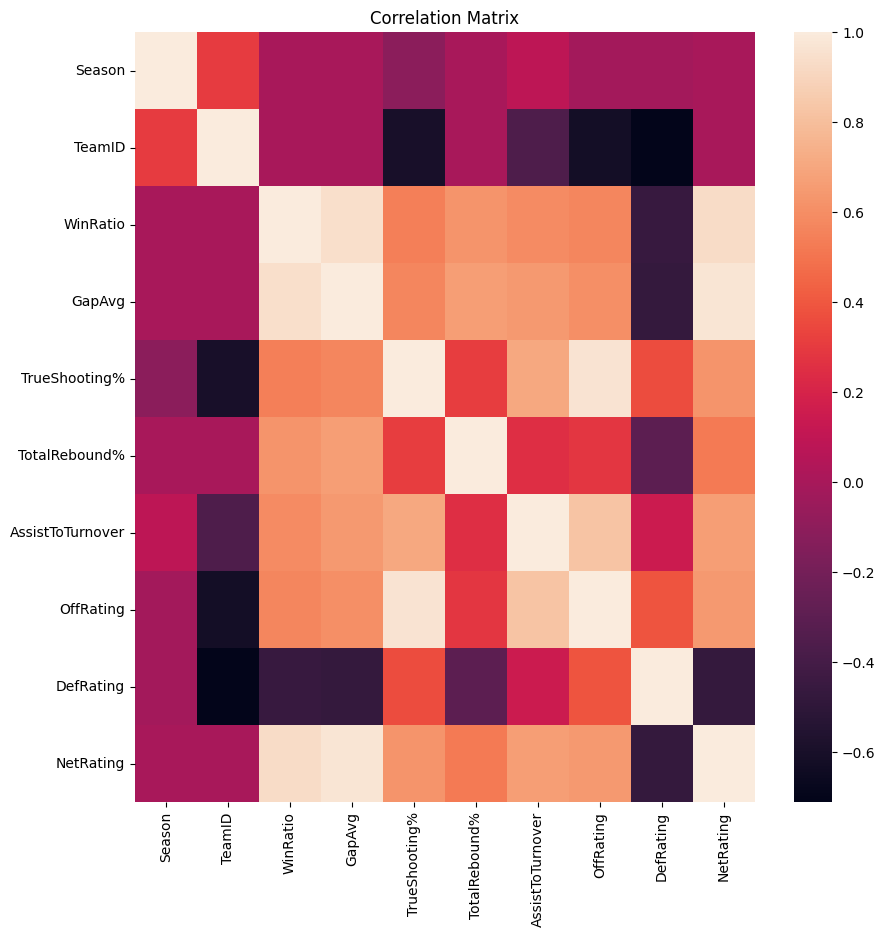

In [54]:
corrs = round(df_features_season.corr(), 2)

import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(corrs)
plt.title('Correlation Matrix')
plt.show()

### Tourney Results 

In [55]:
df_tourney_results = pd.concat([
  pd.read_csv("march-machine-learning-mania-2023/MNCAATourneyCompactResults.csv"),
  pd.read_csv("march-machine-learning-mania-2023/WNCAATourneyCompactResults.csv")
], ignore_index=True)

df_tourney_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

## Feature Engineering

### Train Data

In [56]:
df = df_tourney_results.copy()
df = df[df['Season'] >= 2016].reset_index(drop=True)
# df.head()

#### Seeds

In [57]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'WTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})

df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedL'})

In [58]:
def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

In [59]:
df['SeedW'] = df['SeedW'].apply(treat_seed)
df['SeedL'] = df['SeedL'].apply(treat_seed)
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL
0,2016,134,1195,96,1192,65,16,16
1,2016,134,1455,70,1435,50,11,11
2,2016,135,1221,59,1380,55,16,16
3,2016,135,1276,67,1409,62,11,11
4,2016,136,1114,85,1345,83,12,5


#### Season Stats

In [60]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'WinRatio': 'WinRatioW',
    'GapAvg': 'GapAvgW',
    'TrueShooting%' : 'TrueShootingW',
    'TotalRebound%' : 'TotalReboundW',
    'AssistToTurnover' : 'AssistToTurnoverW',
    'OffRating' : 'OffRatingW',
    'DefRating' : 'DefRatingW',
    'NetRating' : 'NetRatingW',
}).drop(columns='TeamID', axis=1)
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'WinRatio': 'WinRatioL',
    'GapAvg': 'GapAvgL',
    'TrueShooting%' : 'TrueShootingL',
    'TotalRebound%' : 'TotalReboundL',
    'AssistToTurnover' : 'AssistToTurnoverL',
    'OffRating' : 'OffRatingL',
    'DefRating' : 'DefRatingL',
    'NetRating' : 'NetRatingL',
}).drop(columns='TeamID', axis=1)
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,WinRatioW,GapAvgW,...,DefRatingW,NetRatingW,WinRatioL,GapAvgL,TrueShootingL,TotalReboundL,AssistToTurnoverL,OffRatingL,DefRatingL,NetRatingL
0,2016,134,1195,96,1192,65,16,16,0.551724,2.724138,...,89.733136,2.796919,0.548387,-1.677419,0.551992,0.461159,1.084367,93.023619,93.011525,0.012094
1,2016,134,1455,70,1435,50,11,11,0.741935,13.709677,...,80.251647,14.255515,0.593750,9.406250,0.572964,0.508656,1.278075,97.567177,83.204633,14.362544
2,2016,135,1221,59,1380,55,16,16,0.424242,-4.333333,...,93.839799,-5.128661,0.612903,1.870968,0.527352,0.484554,0.911681,90.325959,86.226258,4.099701
3,2016,135,1276,67,1409,62,11,11,0.636364,6.242424,...,91.844232,9.245695,0.645161,4.322581,0.543994,0.486559,1.268657,93.882495,87.282602,6.599894
4,2016,136,1114,85,1345,83,12,5,0.870968,9.935484,...,81.264621,15.238154,0.764706,13.147059,0.578135,0.574266,1.472906,98.187087,84.600804,13.586282


#### Add Symmetrical

In [61]:
def add_losing_matches(df):
  win_rename = {
    "WTeamID": "TeamIDA", 
    "WScore" : "ScoreA", 
    "LTeamID" : "TeamIDB",
    "LScore": "ScoreB",
    }
  win_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('W')})
  win_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('L')})

  lose_rename = {
    "WTeamID": "TeamIDB", 
    "WScore" : "ScoreB", 
    "LTeamID" : "TeamIDA",
    "LScore": "ScoreA",
  }
  lose_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('W')})
  lose_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('L')})

  win_df = df.copy()
  lose_df = df.copy()

  win_df = win_df.rename(columns=win_rename)
  lose_df = lose_df.rename(columns=lose_rename)

  return pd.concat([win_df, lose_df], axis=0, sort=False)
df = add_losing_matches(df)

#### Add Differences

In [62]:
cols_to_diff = [
    'Seed', 'WinRatio', 'GapAvg', 'TrueShooting', 'TotalRebound', 'AssistToTurnover', 'OffRating', 'DefRating', 'NetRating'
]
for col in cols_to_diff:
    df[col + 'Diff'] = df[col + 'A'] - df[col + 'B']
df.head()

,Season,DayNum,TeamIDA,ScoreA,TeamIDB,ScoreB,SeedA,SeedB,WinRatioA,GapAvgA,...,NetRatingB,SeedDiff,WinRatioDiff,GapAvgDiff,TrueShootingDiff,TotalReboundDiff,AssistToTurnoverDiff,OffRatingDiff,DefRatingDiff,NetRatingDiff
0,2016,134,1195,96,1192,65,16,16,0.551724,2.724138,...,0.012094,0,0.003337,4.401557,-0.009675,0.065327,-0.009655,-0.493564,-3.278389,2.784825
1,2016,134,1455,70,1435,50,11,11,0.741935,13.709677,...,14.362544,0,0.148185,4.303427,-0.031594,0.023883,0.177663,-3.060015,-2.952986,-0.107028
2,2016,135,1221,59,1380,55,16,16,0.424242,-4.333333,...,4.099701,0,-0.188661,-6.204301,-0.006166,-0.026701,0.356275,-1.614821,7.613541,-9.228363
3,2016,135,1276,67,1409,62,11,11,0.636364,6.242424,...,6.599894,0,-0.008798,1.919844,0.038405,0.005756,0.270284,7.207432,4.561631,2.645801
4,2016,136,1114,85,1345,83,12,5,0.870968,9.935484,...,13.586282,7,0.106262,-3.211575,-0.016436,-0.082699,-0.211077,-1.684312,-3.336184,1.651872


### Test Data

#### Preparing

In [63]:
df_test = pd.read_csv("march-machine-learning-mania-2023/SampleSubmission2023.csv")
df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
df_test['TeamIDA'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
df_test['TeamIDB'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))
df_test.head()

,ID,Pred,Season,TeamIDA,TeamIDB
0,2023_1101_1102,0.5,2023,1101,1102
1,2023_1101_1103,0.5,2023,1101,1103
2,2023_1101_1104,0.5,2023,1101,1104
3,2023_1101_1105,0.5,2023,1101,1105
4,2023_1101_1106,0.5,2023,1101,1106


#### Seeds

In [64]:
df_test = pd.merge(
  df_test,
  df_seeds,
  how='left',
  left_on=['Season', 'TeamIDA'],
  right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'}).fillna('W00')
df_test = pd.merge(
  df_test, 
  df_seeds, 
  how='left', 
  left_on=['Season', 'TeamIDB'], 
  right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedB'}).fillna('W00')
df_test['SeedA'] = df_test['SeedA'].apply(treat_seed)
df_test['SeedB'] = df_test['SeedB'].apply(treat_seed)
df_test.head()

,ID,Pred,Season,TeamIDA,TeamIDB,SeedA,SeedB
0,2023_1101_1102,0.5,2023,1101,1102,0,0
1,2023_1101_1103,0.5,2023,1101,1103,0,0
2,2023_1101_1104,0.5,2023,1101,1104,0,1
3,2023_1101_1105,0.5,2023,1101,1105,0,0
4,2023_1101_1106,0.5,2023,1101,1106,0,0


#### Season Stats

In [65]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIDA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'WinRatio': 'WinRatioA',
    'GapAvg': 'GapAvgA',
    'TrueShooting%' : 'TrueShootingA',
    'TotalRebound%' : 'TotalReboundA',
    'AssistToTurnover' : 'AssistToTurnoverA',
    'OffRating' : 'OffRatingA',
    'DefRating' : 'DefRatingA',
    'NetRating' : 'NetRatingA',
}).drop(columns='TeamID', axis=1)

df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIDB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'WinRatio': 'WinRatioB',
    'GapAvg': 'GapAvgB',
    'TrueShooting%' : 'TrueShootingB',
    'TotalRebound%' : 'TotalReboundB',
    'AssistToTurnover' : 'AssistToTurnoverB',
    'OffRating' : 'OffRatingB',
    'DefRating' : 'DefRatingB',
    'NetRating' : 'NetRatingB',
}).drop(columns='TeamID', axis=1)

In [66]:
def average_if_na(df, features):
  for feature in features:
    df[feature] = df[feature].fillna(df[feature].mean())

In [67]:
not_feature = ['ID', 'Pred', 'Season', 'TeamIDA', 'TeamIDB']
features = [col for col in df_test.columns.values if col not in not_feature]
average_if_na(df_test, features)


#### Differences

In [68]:
for col in cols_to_diff:
    df_test[col + 'Diff'] = df_test[col + 'A'] - df_test[col + 'B']

### Target

In [69]:
df['ScoreDiff'] = df['ScoreA'] - df["ScoreB"]
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)

## Feature selection

In [70]:
def variants(features):
  res = []
  for feature in features:
    res.append(feature + "A")
    res.append(feature + "B")
    res.append(feature + "Diff")
  return res

In [71]:
not_feature = ['Season', 'DayNum', 'TeamIDA', 'ScoreA', 'TeamIDB', 'ScoreB', 'ScoreDiff', 'WinA']
actual_features = ['Seed', 'WinRatio', 'GapAvg', 'TrueShooting', 'TotalRebound', 'AssistToTurnover', 'OffRating', 'DefRating', 'NetRating']
also_not = variants([f for f in actual_features if f not in keep])
features = [col for col in df.columns.values if col not in not_feature + also_not]
features

['WinRatioA',
 'GapAvgA',
 'AssistToTurnoverA',
 'OffRatingA',
 'DefRatingA',
 'NetRatingA',
 'WinRatioB',
 'GapAvgB',
 'AssistToTurnoverB',
 'OffRatingB',
 'DefRatingB',
 'NetRatingB',
 'WinRatioDiff',
 'GapAvgDiff',
 'AssistToTurnoverDiff',
 'OffRatingDiff',
 'DefRatingDiff',
 'NetRatingDiff']

## Modelling

In [72]:
def rescale(features, df_train, df_val, df_test=None):
  min_ = df_train[features].min()
  max_ = df_train[features].max()
  
  df_train[features] = (df_train[features] - min_) / (max_ - min_)
  df_val[features] = (df_val[features] - min_) / (max_ - min_)
  
  if df_test is not None:
      df_test[features] = (df_test[features] - min_) / (max_ - min_)
      
  return df_train, df_val, df_test

### Cross Validation

In [73]:
def kfold(df, df_test_=None, features=features, plot=False, verbose=0, mode="ridge", c=1, penalty='l2'):
  seasons = df['Season'].unique()
  cvs = []
  roc_aucs = []
  pred_tests = []
  target = "ScoreDiff" if mode == "reg" else "WinA"
  
  for season in seasons[1:]:
    if verbose:
      print(f'\nValidating on season {season}')
    
    df_train = df[df['Season'] < season].reset_index(drop=True).copy()
    df_val = df[df['Season'] == season].reset_index(drop=True).copy()
    df_test = df_test_.copy()
    
    df_train, df_val, df_test = rescale(features, df_train, df_val, df_test)
    
    if mode == "ridge":
      model = Ridge(alpha=1/c)
    elif mode == "nb":
      model = GaussianNB()
    elif mode == "logreg":
      model = LogisticRegression(penalty=penalty, C=c)

    model.fit(df_train[features], df_train[target])
    
    if mode == "ridge":
        pred = model.predict(df_val[features])
    else:
        pred = model.predict_proba(df_val[features])[:, 1]
    
    if df_test is not None:
      if mode == "ridge":
        pred_test = model.predict(df_test[features])
        pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min())
      else:
        pred_test = model.predict_proba(df_test[features])[:, 1]
          
      pred_tests.append(pred_test)
        
    # if plot:
    #   plt.figure(figsize=(15, 6))
    #   plt.subplot(1, 2, 1)
    #   plt.scatter(pred, df_val['ScoreDiff'].values, s=5)
    #   plt.title('Prediction vs Score Diff')
    #   plt.grid(True)
    #   plt.subplot(1, 2, 2)
    #   sns.histplot(pred, bins=20)
    #   plt.title('Predictions probability repartition')
    #   plt.show()
    
    pred = (pred - pred.min()) / (pred.max() - pred.min())
    pred = np.clip(pred, 0, 1)

    score = ((df_val['WinA'].values - pred) ** 2).mean()
    cvs.append(score)

    roc_auc = roc_auc_score(df_val["WinA"], pred)
    roc_aucs.append(roc_auc)

    if verbose:
      print(f'\t -> CV Score {score:.3f}')
      print(f'\t -> ROC AUC Score: {roc_auc:.3f}\n')
      
  mean_cv = np.mean(cvs)
  mean_roc_auc = np.mean(roc_aucs)
  print(f'Local CV is {mean_cv:.3f}')
  print(f'Local ROC AUC is {mean_roc_auc:.3f}')
  # Calculate accuracy
  return pred_tests, mean_cv, mean_roc_auc

## Results

### Hyperparameter Tuning

In [74]:
ridge_cvs = []
ridge_roc_aucs = []
for C in range(25):
    print(f'\nFor C = {C+1}')
    pred_tests, mean_cv, mean_roc_auc = kfold(df, df_test, plot=False, verbose=1, mode="ridge", c=C+1)
    ridge_cvs.append(mean_cv)
    ridge_roc_aucs.append(mean_roc_auc)


For C = 1

Validating on season 2017
	 -> CV Score 0.213
	 -> ROC AUC Score: 0.736


Validating on season 2018


	 -> CV Score 0.216
	 -> ROC AUC Score: 0.730


Validating on season 2019
	 -> CV Score 0.200
	 -> ROC AUC Score: 0.765


Validating on season 2021
	 -> CV Score 0.219
	 -> ROC AUC Score: 0.714


Validating on season 2022
	 -> CV Score 0.220
	 -> ROC AUC Score: 0.698

Local CV is 0.214
Local ROC AUC is 0.729

For C = 2

Validating on season 2017
	 -> CV Score 0.213
	 -> ROC AUC Score: 0.733


Validating on season 2018
	 -> CV Score 0.216
	 -> ROC AUC Score: 0.729


Validating on season 2019
	 -> CV Score 0.200
	 -> ROC AUC Score: 0.767


Validating on season 2021
	 -> CV Score 0.219
	 -> ROC AUC Score: 0.715


Validating on season 2022
	 -> CV Score 0.220
	 -> ROC AUC Score: 0.700

Local CV is 0.214
Local ROC AUC is 0.729

For C = 3

Validating on season 2017
	 -> CV Score 0.214
	 -> ROC AUC Score: 0.732


Validating on season 2018
	 -> CV Score 0.216
	 -> ROC AUC Score: 0.729


Validating on season 2019
	 -> CV Score 0.200
	 -> ROC AUC Score: 0.767


Validating on season 2021
	 -> CV 

In [75]:
log_cvs = []
log_roc_aucs = []
for C in range(25):
    print(f'\nFor C = {C+1}')
    pred_tests, mean_cv, mean_roc_auc = kfold(df, df_test, plot=False, verbose=1, mode="logreg", c=C+1)
    log_cvs.append(mean_cv)
    log_roc_aucs.append(mean_roc_auc)


For C = 1

Validating on season 2017
	 -> CV Score 0.208
	 -> ROC AUC Score: 0.738


Validating on season 2018
	 -> CV Score 0.212
	 -> ROC AUC Score: 0.726


Validating on season 2019
	 -> CV Score 0.196
	 -> ROC AUC Score: 0.762


Validating on season 2021
	 -> CV Score 0.219
	 -> ROC AUC Score: 0.712


Validating on season 2022
	 -> CV Score 0.221
	 -> ROC AUC Score: 0.693

Local CV is 0.211
Local ROC AUC is 0.726

For C = 2

Validating on season 2017
	 -> CV Score 0.208
	 -> ROC AUC Score: 0.738


Validating on season 2018
	 -> CV Score 0.212
	 -> ROC AUC Score: 0.727


Validating on season 2019
	 -> CV Score 0.195
	 -> ROC AUC Score: 0.765


Validating on season 2021
	 -> CV Score 0.218
	 -> ROC AUC Score: 0.715


Validating on season 2022
	 -> CV Score 0.221
	 -> ROC AUC Score: 0.694

Local CV is 0.211
Local ROC AUC is 0.728

For C = 3

Validating on season 2017
	 -> CV Score 0.209
	 -> ROC AUC Score: 0.740


Validating on season 2018
	 -> CV Score 0.212
	 -> ROC AUC Score: 0.72

C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	 -> CV Score 0.221
	 -> ROC AUC Score: 0.697

Local CV is 0.211
Local ROC AUC is 0.730

For C = 15

Validating on season 2017
	 -> CV Score 0.212
	 -> ROC AUC Score: 0.737


Validating on season 2018
	 -> CV Score 0.212
	 -> ROC AUC Score: 0.724


Validating on season 2019
	 -> CV Score 0.194
	 -> ROC AUC Score: 0.770


Validating on season 2021
	 -> CV Score 0.217
	 -> ROC AUC Score: 0.719


Validating on season 2022
	 -> CV Score 0.221
	 -> ROC AUC Score: 0.698

Local CV is 0.211
Local ROC AUC is 0.730

For C = 16

Validating on season 2017
	 -> CV Score 0.212
	 -> ROC AUC Score: 0.737


Validating on season 2018
	 -> CV Score 0.212
	 -> ROC AUC Score: 0.724


Validating on season 2019
	 -> CV Score 0.194
	 -> ROC AUC Score: 0.770


Validating on season 2021
	 -> CV Score 0.217
	 -> ROC AUC Score: 0.719


Validating on season 2022
	 -> CV Score 0.221
	 -> ROC AUC Score: 0.698

Local CV is 0.211
Local ROC AUC is 0.730

For C = 17

Validating on season 2017
	 -> CV Score 0.212
	 -> RO

C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	 -> CV Score 0.217
	 -> ROC AUC Score: 0.719


Validating on season 2022
	 -> CV Score 0.221
	 -> ROC AUC Score: 0.698

Local CV is 0.211
Local ROC AUC is 0.730

For C = 18

Validating on season 2017
	 -> CV Score 0.212
	 -> ROC AUC Score: 0.737


Validating on season 2018
	 -> CV Score 0.212
	 -> ROC AUC Score: 0.724


Validating on season 2019
	 -> CV Score 0.194
	 -> ROC AUC Score: 0.770


Validating on season 2021
	 -> CV Score 0.217
	 -> ROC AUC Score: 0.719


Validating on season 2022
	 -> CV Score 0.221
	 -> ROC AUC Score: 0.698

Local CV is 0.211
Local ROC AUC is 0.730

For C = 19

Validating on season 2017
	 -> CV Score 0.212
	 -> ROC AUC Score: 0.737


Validating on season 2018
	 -> CV Score 0.212
	 -> ROC AUC Score: 0.724


Validating on season 2019
	 -> CV Score 0.194
	 -> ROC AUC Score: 0.770


Validating on season 2021
	 -> CV Score 0.217
	 -> ROC AUC Score: 0.720


Validating on season 2022
	 -> CV Score 0.221
	 -> ROC AUC Score: 0.698

Local CV is 0.211
Local ROC AUC i

C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	 -> CV Score 0.217
	 -> ROC AUC Score: 0.720


Validating on season 2022
	 -> CV Score 0.221
	 -> ROC AUC Score: 0.699

Local CV is 0.211
Local ROC AUC is 0.730

For C = 22

Validating on season 2017
	 -> CV Score 0.213
	 -> ROC AUC Score: 0.737


Validating on season 2018
	 -> CV Score 0.213
	 -> ROC AUC Score: 0.724


Validating on season 2019
	 -> CV Score 0.194
	 -> ROC AUC Score: 0.770


Validating on season 2021
	 -> CV Score 0.217
	 -> ROC AUC Score: 0.720


Validating on season 2022
	 -> CV Score 0.221
	 -> ROC AUC Score: 0.699

Local CV is 0.211
Local ROC AUC is 0.730

For C = 23

Validating on season 2017
	 -> CV Score 0.213
	 -> ROC AUC Score: 0.738


Validating on season 2018
	 -> CV Score 0.213
	 -> ROC AUC Score: 0.724


Validating on season 2019
	 -> CV Score 0.194
	 -> ROC AUC Score: 0.770


Validating on season 2021
	 -> CV Score 0.217
	 -> ROC AUC Score: 0.720


Validating on season 2022
	 -> CV Score 0.221
	 -> ROC AUC Score: 0.699

Local CV is 0.211
Local ROC AUC i

In [76]:
cs = list(range(1, 26))

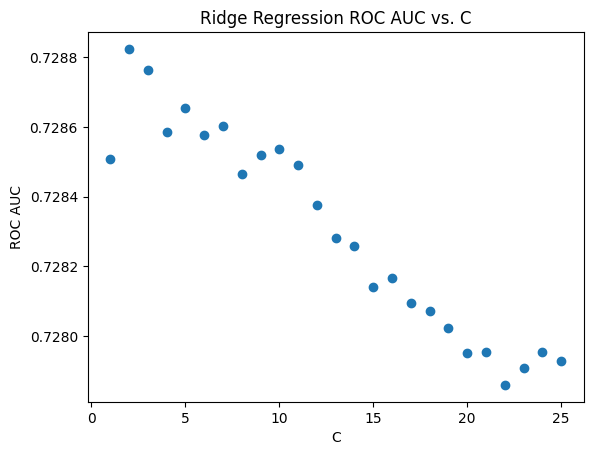

In [77]:
plt.scatter(cs, ridge_roc_aucs)
plt.title("Ridge Regression ROC AUC vs. C")
plt.xlabel("C")
plt.ylabel("ROC AUC")
plt.show()

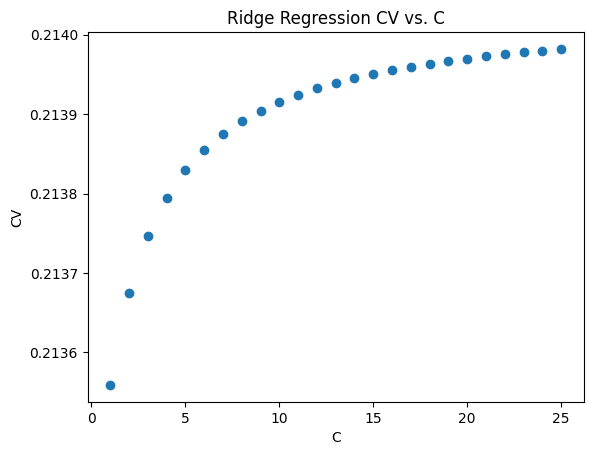

In [78]:
plt.scatter(cs, ridge_cvs)
plt.title("Ridge Regression CV vs. C")
plt.xlabel("C")
plt.ylabel("CV")
plt.show()

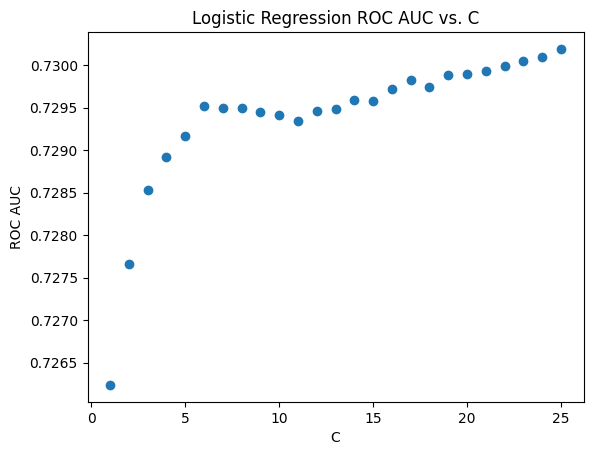

In [79]:
plt.scatter(cs, log_roc_aucs)
plt.title("Logistic Regression ROC AUC vs. C")
plt.xlabel("C")
plt.ylabel("ROC AUC")
plt.show()

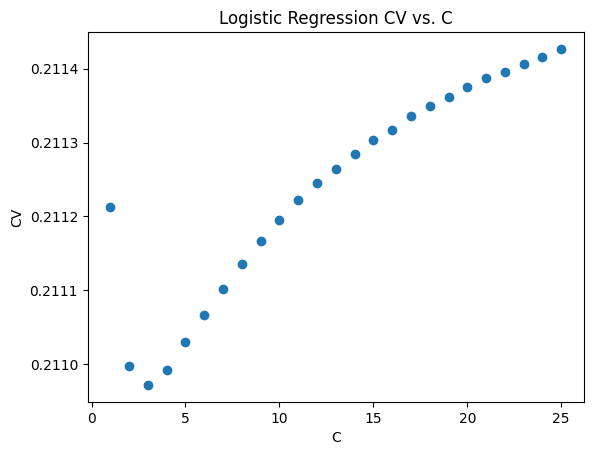

In [80]:
plt.scatter(cs, log_cvs)
plt.title("Logistic Regression CV vs. C")
plt.xlabel("C")
plt.ylabel("CV")
plt.show()

### Final Results

#### Baseline

In [81]:
from sklearn.dummy import DummyClassifier

baseline = DummyClassifier(strategy="most_frequent")

df_baseline = df.copy()

df_baseline = rescale(features, df_baseline, df.copy(), df.copy())

baseline_accuracy = sum(cross_val_score(baseline, df[features], df['WinA'], scoring='accuracy')) / 5
baseline_score = sum(cross_val_score(baseline, df[features], df['WinA'], scoring='roc_auc')) / 5

print("Baseline accuracy:", baseline_accuracy)
print("Baseline score (roc_auc):", baseline_score)

Baseline accuracy: 0.4987220447284345
Baseline score (roc_auc): 0.5


#### Gaussian Naive Bayes

In [82]:
pred_tests, mean_cv, mean_roc_auc = kfold(df, df_test, plot=False, verbose=1, mode="nb")


Validating on season 2017
	 -> CV Score 0.285
	 -> ROC AUC Score: 0.720


Validating on season 2018
	 -> CV Score 0.301
	 -> ROC AUC Score: 0.712


Validating on season 2019
	 -> CV Score 0.270
	 -> ROC AUC Score: 0.755


Validating on season 2021
	 -> CV Score 0.299
	 -> ROC AUC Score: 0.709


Validating on season 2022
	 -> CV Score 0.290
	 -> ROC AUC Score: 0.699

Local CV is 0.289
Local ROC AUC is 0.719


#### Logistic Regression

In [83]:
pred_tests, mean_cv, mean_roc_auc = kfold(df, df_test, plot=False, verbose=1, mode="logreg", c=1)


Validating on season 2017
	 -> CV Score 0.208
	 -> ROC AUC Score: 0.738


Validating on season 2018
	 -> CV Score 0.212
	 -> ROC AUC Score: 0.726


Validating on season 2019
	 -> CV Score 0.196
	 -> ROC AUC Score: 0.762


Validating on season 2021
	 -> CV Score 0.219
	 -> ROC AUC Score: 0.712


Validating on season 2022
	 -> CV Score 0.221
	 -> ROC AUC Score: 0.693

Local CV is 0.211
Local ROC AUC is 0.726


#### Ridge Regression

In [84]:
pred_tests, mean_cv, mean_roc_auc = kfold(df, df_test, plot=False, verbose=1)


Validating on season 2017
	 -> CV Score 0.213
	 -> ROC AUC Score: 0.736


Validating on season 2018
	 -> CV Score 0.216
	 -> ROC AUC Score: 0.730


Validating on season 2019
	 -> CV Score 0.200
	 -> ROC AUC Score: 0.765


Validating on season 2021
	 -> CV Score 0.219
	 -> ROC AUC Score: 0.714


Validating on season 2022
	 -> CV Score 0.220
	 -> ROC AUC Score: 0.698

Local CV is 0.214
Local ROC AUC is 0.729
